Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import glob

init_notebook_mode(connected=True)

sns.set()
sns.set_style("white")

%matplotlib inline

Function definitions

In [2]:
def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

def remove_nan_transpose(varlst):
    Varlst = np.array(varlst)
    res = []
    for i in range(Varlst.shape[1]):
        lst = Varlst[:,i]
        
        #Remove nan
        lst = lst[~np.isnan(lst)]
        
        res.append(lst)
        
    return res

def start_simulation_parallel(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # I update here:
        I += (sig * K * (y - y0)) / 100 * dt
        

        # u-v and y update
        if sig == 0:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
        else:
            u += (-u + thresh_exp(Wut * I - Wuv * v - 50 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 50 + np.random.randn(ntrials) * sigma)) / tau * dt

        y += (-y + u - v + np.random.randn(ntrials) * sigma) / 100 * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)    
        
    return u_lst, v_lst, y_lst, I_lst, sig_lst

# Functions for using in a for loop
def get_times_lst_from_y(ylst, threshold):
    ndiscard = 10
    # Discard first 10 samples
    ylst = ylst[ndiscard:]
    times_lst = []
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(ylst[:,k]) > threshold:
            times_lst.append(np.nonzero(ylst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst) + ndiscard

def simulate_trial(ntrials=1000, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    
    nbin = int(duration / PARAMS_DICT['dt'])

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * 0.7, 
                  np.ones(ntrials) * 0.2,
                  np.ones(ntrials) * 0.5,
                  0.0]

    if nstages > 1:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
    else:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, 100)

    # For subsequent runs, flip the state every 100 trials
    for k in range((nstages - 2) * 2):
        #acoefs = 1 - acoefs
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        if state_init[4] == 0.0:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
        else:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2

    if nstages > 1:
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2
        
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 200)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        
        siglst2[nbin] = 1
        siglst += siglst2
    else:
        siglst[nbin] = 1
        ylst2 = ylst

    return ulst, vlst, ylst, Ilst, siglst, ylst2

def plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    
    ulst_arr = np.array(ulst)
    vlst_arr = np.array(vlst)
    ylst_arr = np.array(ylst)
    Ilst_arr = np.array(Ilst)
    
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    #wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst_arr, 'b', alpha=0.2)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst, alpha=0.5)
    #ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst_arr, 'b', alpha=0.2)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst, alpha=0.5)
    #ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst_arr, 'b', alpha=0.2)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst, alpha=0.5)
    #ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst2, alpha=0.2)
    ax[2].hlines(0.7, 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst_arr, 'b', alpha=0.2)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst, alpha=0.5)
    #ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');
    
def get_times_lst_from_y(ylst, threshold):
    ndiscard = 10
    # Discard first 10 samples
    ylst = ylst[ndiscard:]
    times_lst = []
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(ylst[:,k]) > threshold:
            times_lst.append(np.nonzero(ylst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst) + ndiscard

def start_simulation_to_thresh(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # I update here:
        I += (sig * K * (y - y0)) / 100 * dt
        

        # u-v and y update
        if sig == 0:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
        else:
            u += (-u + thresh_exp(Wut * I - Wuv * v - 50 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 50 + np.random.randn(ntrials) * sigma)) / tau * dt

        y += (-y + u - v + np.random.randn(ntrials) * sigma) / 100 * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)
        
        y[y > y0] = np.nan
        
        #print(np.sum(~np.isnan(y)))
        # Terminate once threshold is reached
        if np.sum(~np.isnan(y)) == 0:
            #print(np.sum(~np.isnan(y)))
            #print('Breaking at ', i, '...')
            break
            
    
    return u_lst, v_lst, y_lst, I_lst, sig_lst

Parameters

In [3]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'K': 8.0,
              'sigma': 0.05,
              'alpha': 1}

Now lets try doing some phase shifts

In [4]:
def gauss_derivative(x,sig,amp):
    y = -amp / np.sqrt(2*np.pi*np.power(sig,2)) * x / np.power(sig,2) * np.exp( -np.power(x,2) / (2*np.power(sig,2)) )
    
    return y
    
def dual_process_model_generalized(state_init, params, niter, durations):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    alpha = params['alpha']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    uS = u.copy()
    vS = v.copy()
    yS = y.copy()
    
    IP = I.copy()
    uP = u.copy()
    vP = v.copy()
    yP = y.copy()
        
    sig_lst = []
    u_sim = []
    v_sim = []
    y_sim = []
    I_lst = []
    
    u_p = []
    v_p = []
    y_p = []
    I_p = []
    production_lst = []
    
    durs = np.cumsum(np.divide(durations,dt))
    durs = durs.astype(int)
    
    for i in range(niter): 
        
        if any(i == durs):
            sig = 1.0
            #print('flash')
        else:
            sig = 0.0
        
        # I update here:
        I += (sig * K * (yS - y0)) / 100 * dt
        

        # u-v and y update
        if sig == 0:
            uS += (-uS + thresh_exp(Wut * I - Wuv * vS + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
            vS += (-vS + thresh_exp(Wvt * I - Wvu * uS + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
        else:
            uS += (-uS + thresh_exp(Wut * I - Wuv * vS - 50 + np.random.randn(ntrials) * sigma)) / tau * dt
            vS += (-vS + thresh_exp(Wvt * I - Wvu * uS + 50 + np.random.randn(ntrials) * sigma)) / tau * dt

        yS += (-yS + uS - vS + np.random.randn(ntrials) * sigma) / 100 * dt

        v_sim.append(vS.copy())
        u_sim.append(uS.copy())
        y_sim.append(yS.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig) 
        
        
        # u-v and y update
        sigP = (yP >= y0).astype('float')
        uP += (-uP + thresh_exp(Wut * IP - Wuv * vP - 50 * sigP + np.random.randn(ntrials) * sigma)) / tau * dt
        vP += (-vP + thresh_exp(Wvt * IP - Wvu * uP + 50 * sigP + np.random.randn(ntrials) * sigma)) / tau * dt

        yP += (-yP + uP - vP + np.random.randn(ntrials) * sigma) / 100 * dt
        
        yPcurr = yP.copy()
        yScurr = yS.copy()
        
        #if len(y_p) > 1:
        #    yPprev = y_p[-1]
        #    IP = I.copy() + alpha * np.sign(yPcurr - yPprev) * (yPcurr - yScurr)
        
        
        IP = I.copy() + alpha*(yP.copy() - yS.copy())
        #print((yP.copy() - yS.copy()))
        #IP = I.copy() - gauss_derivative((yP.copy() - yS.copy()),0.4,alpha)

        v_p.append(vP.copy())
        u_p.append(uP.copy())
        y_p.append(yP.copy())
        I_p.append(IP.copy())
        production_lst.append(sigP)
        
    return u_sim, v_sim, y_sim, I_lst, sig_lst, u_p, v_p, y_p, I_p, production_lst

In [5]:
def simulate_synchronization2(ntrials=1, durations=[600, 600, 600, 600, 1000, 600, 600], sigma=0, K=3.0, initI=0.7, alpha=0.5):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    PARAMS_DICT['alpha'] = alpha
    
    nbin = int(sum(np.divide(durations,PARAMS_DICT['dt'])))
    #print(nbin)
    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * 0.87, 
                  np.ones(ntrials) * 0.25,
                  np.ones(ntrials) * 0.5,
                  0.0]

    usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = dual_process_model_generalized(state_init, PARAMS_DICT, nbin, durations)


    return usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, np.array(production_lst) 

def asynchronies(sig_lst,production_lst,dt):
    press_times = np.multiply(np.nonzero(production_lst)[0],dt)
    flash_times = np.multiply(np.nonzero(sig_lst)[0],dt)
    if np.size(flash_times) >= np.size(press_times):
        asynch = press_times - flash_times[:np.size(press_times)]
    else:
        asynch = press_times[:np.size(flash_times)] - flash_times
    return asynch, press_times, flash_times
        
def asynchronies_multi(sig_lst,production_lst,dt):
    Production_lst = np.array(production_lst)
    asynch_lst, press_times_lst, flash_times_lst = [], [], []
    
    # Compute asynchronies for each column of the matrix
    for i in range(Production_lst.shape[1]):
        asynch_single, press_times_single, flash_times_single = asynchronies(sig_lst, 
                            Production_lst[:,i], dt)
        asynch_lst.append(asynch_single)
        press_times_lst.append(press_times_single)
        flash_times_lst.append(flash_times_single)
        
    return asynch_lst, press_times_lst, flash_times_lst

def isi_ipi(sig_lst,production_lst,dt):
    press_times = np.multiply(np.nonzero(production_lst),dt)
    flash_times = np.multiply(np.nonzero(sig_lst),dt)
    
    isi = np.diff(flash_times)
    ipi = np.diff(press_times)
    
    return isi, ipi, press_times, flash_times

Event onset shift

## Synchronization-continuation simulation

Here, we try to simulate the synchronization-continuation experiment, and compare the simulation to data provided by Evan.

[[ 0  0  0  0  0  0  0  0  0 67  0  0  0  0  0  0  0  0  0 72  0  0  0  0
   0  0  0  0  0 71  0  0  0  0  0  0  0  0  0 71  0  0  0  0  0  0  0  0
   0 70  0  0  0  0  0  0  0  0  0 51  0  0  0  0  0  0  0  0  0 50  0  0
   0  0  0  0  0  0  0 50  0  0  0  0  0  0  0  0  0 50  0  0  0  0  0  0
   0  0  0 50  0  0  0  0  0  0  0  0  0 50  0  0  0  0  0  0  0  0  0 50
   0  0  0  0  0  0  0  0  0 50  0  0  0  0  0  0  0  0  0 50  0  0  0  0
   0  0  0  0  0 50  0  0  0  0  0  0  0  0  0 50  0  0  0  0  0  0  0  0
   0 50  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  1  1 -9  1  1  1  1  1  1  1  1  1 -9  1  1  1  1
   1  1  1  1  1 -9  1  1  1  1  1  1  1  1  1 -9  1  1  1  1  1  1  1  1
   1 -9  1  1  1  1  1  1  1  1  1 -9  1  1  1  1  1  1  1  1  1 -9  1  1
   1  1  1  1  1  1  1 -9  1  1  1  1  1  1  1  1  1 -9  1  1  1  1  1  1
   1  1  1 -9  1  1  1  1  1  1  1  1  1 -9  1  1  1  1  1  1  1  1  1 -9
   1  1  1  1  1  1  1  1  1 -9  1  1  1  1  1  1  1  1  1 -9  1  1  1  1
  

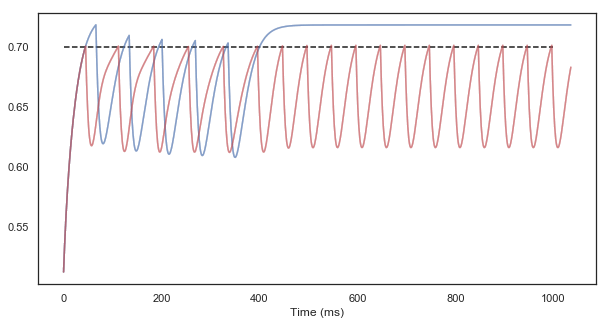

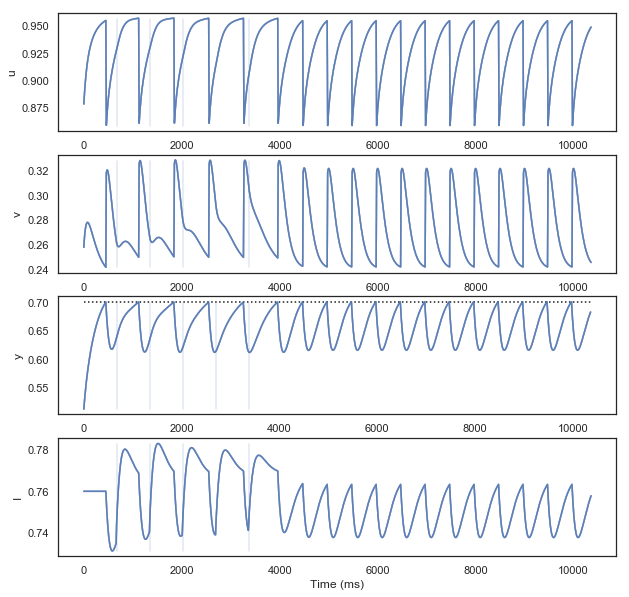

In [6]:
usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization2(ntrials=10, 
                                                                               durations=[675.0] * 5 + [7000], 
                                                                               sigma=0.0, K=2, initI=0.76, alpha = 0.3)


plt.figure(figsize=(10, 5))
#a = remove_nan_transpose(siglst)
#for i in range(len(a)):
#    plt.plot(np.arange(len(a[i])) * 10, a[i], 'b', alpha=0.1)
plt.plot(ysim, 'b', alpha=0.1)
plt.plot(y_p, 'r', alpha=0.1)
plt.xlabel('Time (ms)')
#plt.ylabel('y')
plt.hlines(0.7, 0, 1000*10/PARAMS_DICT['dt'], linestyles='--')
print(np.diff(np.nonzero(production_lst)))


plot_simulation_parallel(u_p, v_p, y_p, I_p, siglst, PARAMS_DICT)


Here, we try to simulate just the synchronization phase to find the appropriate parameters ($K, \alpha, \sigma, I_{init}$)

Some comments: 

* If $\alpha = 0$, the network exhibits a simple integration, with the IPI starting from the mean of the distribution and slowly approaching the desired interval with a rate controlled by $K$.

(500, 900)

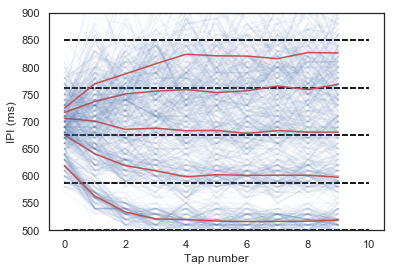

In [7]:
durs = np.linspace(500, 850, 5)

for interval in durs:
    usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization2(ntrials=100, 
                                                                               durations=[interval] * 5 + [10000], 
                                                                               sigma=0.01, K=3, initI=0.77, alpha = 0.0)
    
    # Find the IPI (inter-production interval)
    ipi_lst = []
    for i in range(production_lst.shape[1]):
        single_production = production_lst[:,i]
        #print(len(np.nonzero(single_production)[0]))
        ipi_lst.append(np.diff(np.nonzero(single_production)[0])[:10])

    plt.plot(np.array(ipi_lst).T * 10, 'b', alpha=0.05)
    meanline = np.mean(np.array(ipi_lst), axis=0)
    plt.plot(meanline * 10, 'r')
    plt.hlines(durs, 0, 10, linestyles='--')
    
plt.xlabel('Tap number')
plt.ylabel('IPI (ms)')
plt.ylim((500, 900))

Now we examine the effect of varying $\alpha$. Remember that $\alpha$ controls the coupling between the simulator and the plant to account for the phase of the two.

``IP = I.copy() + alpha*(yP.copy() - yS.copy())``

The simulation shows that as we increase $\alpha$, the increase in bias in the synchronization phase becomes more pronounced.

Text(0,0.5,'IPI (ms)')

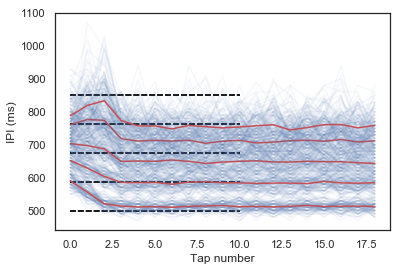

In [8]:
durs = np.linspace(500, 850, 5)
meanITIs = []

for interval in durs:
    usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization2(ntrials=100, 
                                                                               durations=[interval] * 4 + [20000],  
                                                                               sigma=0.01, K=2.5, initI=0.77, alpha = 0.05)
    
    # Find the IPI (inter-production interval)
    ipi_lst = []
    for i in range(production_lst.shape[1]):
        single_production = production_lst[:,i]
        #print(len(np.nonzero(single_production)[0]))
        ipi_lst.append(np.diff(np.nonzero(single_production)[0])[1:20])

    plt.plot(np.array(ipi_lst).T * 10, 'b', alpha=0.05)
    meanline = np.mean(np.array(ipi_lst), axis=0)
    meanITIs.append(meanline)
    plt.plot(meanline * 10, 'r')
    plt.hlines(durs, 0, 10, linestyles='--')
    
plt.xlabel('Tap number')
plt.ylabel('IPI (ms)')
#plt.ylim((500, 900))

Text(0,0.5,'Bias')

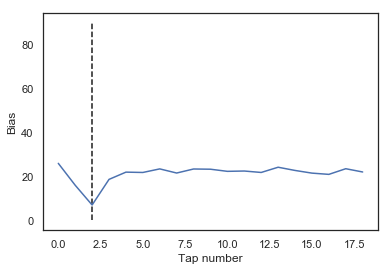

In [9]:
# Plot the bias for all of the conditions
meanITIs = np.array(meanITIs)
bias_individual = meanITIs * 10 - durs[:,np.newaxis]
bias_all_sim = np.sum(bias_individual**2, axis=0)
plt.plot(np.sqrt(bias_all_sim) / len(durs))
plt.vlines(2, 0, 90, linestyles='--')
plt.xlabel('Tap number')
plt.ylabel('Bias')

Now, we compare the result of the simulation to behavioral data.

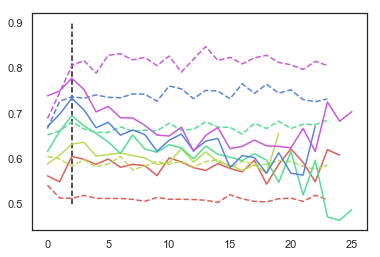

In [10]:
### Simulation ###
durs = np.linspace(500, 850, 5)
meanITIs = []

for interval in durs:
    usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization2(ntrials=40, 
                                                                               durations=[interval] * 4 + [interval * 30],  
                                                                               sigma=0.02, K=4, initI=0.76, alpha = 0.0)
    
    # Find the IPI (inter-production interval)
    ipi_lst = []
    for i in range(production_lst.shape[1]):
        single_production = production_lst[:,i]
        #print(len(np.nonzero(single_production)[0]))
        ipi_lst.append(np.diff(np.nonzero(single_production)[0])[1:25])

    meanline = np.mean(np.array(ipi_lst), axis=0)
    meanITIs.append(meanline)

meanITIs = np.array(meanITIs)
bias_individual = meanITIs * 10 - durs[:,np.newaxis]
bias_all = np.sum(bias_individual**2, axis=0)

### Plotting ###
palette = sns.color_palette('hls', 5)

# Load the processed data
filename = 'AL1_20180718_syncon_ITIs.mat'
data = scipy.io.loadmat(filename)
durs = data['durs'].flatten()
splits = data['allDur_splits']

# Plot the mean IPI
IPI_mean = data['allDur_mean']
for i in range(5):
    plt.plot(IPI_mean[0,i].T, color=palette[i])
    plt.plot(meanITIs[i,:] / 100, '--', color=palette[i]);
    
plt.vlines(2, 0.5, 0.90, linestyles='--')


In [11]:
trials = splits[0,0]
N = trials.shape[0]

# Get number of taps for each trial
ntaps = np.sum(~np.isnan(trials), axis=1)
maxtaps = max(ntaps)

In [12]:
### Simulation, with the correct number of trials ###
#durs = np.linspace(500, 850, 5)
meanITIs = []

for interval in [550]:
    usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization2(ntrials=N, 
                                                                               durations=[interval] * 4 + [interval * (maxtaps + 3)],  
                                                                               sigma=0.02, K=4, initI=0.76, alpha = 0.0)
    
    # Find the IPI (inter-production interval)
    ipi_lst = []
    for i in range(production_lst.shape[1]):
        single_production = production_lst[:,i]
        #print(len(np.nonzero(single_production)[0]))
        tap_intervals = np.diff(np.nonzero(single_production)[0])[1:maxtaps].astype('float')
        tap_intervals[ntaps[i]:] = np.nan
        ipi_lst.append(tap_intervals)

    meanline = np.nanmean(np.array(ipi_lst), axis=0)
    meanITIs.append(meanline)

IPIs = np.array(ipi_lst)
meanITIs = np.array(meanITIs)
bias_individual = meanITIs * 10 - durs[:,np.newaxis]
bias_all = np.sum(bias_individual**2, axis=0)

C:\Users\Sur lab\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

Mean of empty slice



(0.5, 0.9)

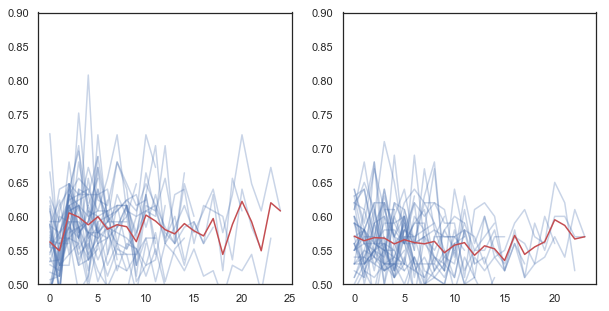

In [13]:
plt.figure(figsize=(10,5))

plt.subplot('121')
plt.plot(trials.T, 'b', alpha=0.3);
plt.plot(np.nanmean(trials, axis=0), 'r')
plt.ylim((0.5, 0.9))


plt.subplot('122')
plt.plot(IPIs.T / 100, 'b', alpha=0.3);
plt.plot(meanITIs[0,:] / 100, 'r');
plt.ylim((0.5, 0.9))

In [14]:
def find_bias_all(IPI_mean, durs, tmax):
    '''IPI_mean: an array of mean intervals
    Returns the average bias profile across the different trial durations'''
    Bias = np.zeros((tmax, 5))

    for i in range(len(IPI_mean)):
        IPI_single = IPI_mean[i].flatten()[:tmax]
        bias_single = IPI_single - durs[i]
        Bias[:,i] = bias_single

    return np.sqrt(np.nanmean(Bias**2, axis=1)) * 1000

In [15]:
dirlst = glob.glob('C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\*_2_*ITIs.mat')

In [16]:
def simulate_sync_cont_bias(ntrials, sigma, K, initI, alpha):
    '''Simulate synchronization continuation and return the array of bias'''
    durs = np.linspace(500, 850, 5)
    meanITIs = []

    for interval in durs:
        usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization2(ntrials=ntrials, 
                                                                                   durations=[interval] * 4 + [20000],  
                                                                                   sigma=sigma, K=K, initI=initI, alpha=alpha)

        # Find the IPI (inter-production interval)
        ipi_lst = []
        for i in range(production_lst.shape[1]):
            single_production = production_lst[:,i]
            #print(len(np.nonzero(single_production)[0]))
            ipi_lst.append(np.diff(np.nonzero(single_production)[0])[1:20])
        meanline = np.mean(np.array(ipi_lst), axis=0)
        meanITIs.append(meanline)

    meanITIs = np.array(meanITIs)
    bias_individual = meanITIs * 10 - durs[:,np.newaxis]
    bias_all_sim = np.sum(bias_individual**2, axis=0)
    return np.sqrt(bias_all_sim) / len(durs)


C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\AL_2_20170719_SynCon_ITIs.mat
C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\ER_2_20170718_SynCon_ITIs.mat
C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\FK_2_20170721_SynCon_ITIs.mat
C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\KL_2_20170721_SynCon_ITIs.mat
C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\MW_2_20170720_SynCon_ITIs.mat
C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\RC_2_20170721_SynCon_ITIs.mat


Text(0,0.5,'Bias (ms)')

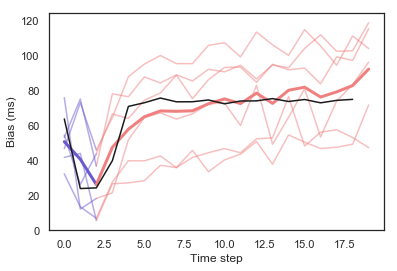

In [17]:
# Load the processed data
plotlst = [0,3,4,5,6,7]
tmax = 20
bias_all_lst = np.zeros((len(plotlst), tmax))
color1 = 'slateblue'
color2 = 'lightcoral'

for id, i in enumerate(plotlst):
    filename = dirlst[i]
    print(filename)
    data = scipy.io.loadmat(filename)
    durs = data['durs'].flatten()
    splits = data['allDur_splits']

    # Plot the mean IPI
    IPI_mean = data['allDur_mean'][0]
    bias = find_bias_all(IPI_mean, durs, tmax=tmax)
    bias_all_lst[id,:] = bias
    plt.plot(bias[:3], color1, alpha=0.5)
    plt.plot(range(2,20), bias[2:], color2, alpha=0.5)
    
bias_sim = simulate_sync_cont_bias(ntrials=20, sigma=0.01, K=3.5, initI=0.755, alpha=0.25)

## Plot Figure 8e
plt.plot(np.nanmean(bias_all_lst,axis=0)[:3], color1, linewidth=3)
plt.plot(range(2,20), np.nanmean(bias_all_lst,axis=0)[2:], color2, linewidth=3)
plt.plot(bias_sim, 'k')
plt.xlabel('Time step')
plt.ylabel('Bias (ms)')